In [43]:
import pandas as pd
import numpy as np
# Load the CSV file
df = pd.read_csv('clean3.csv')
df.shape

(6054, 53)

In [44]:
def price_transform(price):
    return np.exp(price)
    #return price

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(1)
df['log_price'] = np.log(df['total_price'])
#df['log_price'] = df['total_price']
# Drop non-numeric standardized columns that have encoded versions
columns_to_drop = [
    'district_standardized', 
    'building_type_standardized',
    'windows_type_standardized', 
    'user_type_standardized',
    'heating_standardized', 
    'construction_status_standardized',
    'building_material_standardized', 
    'floor_standardized',
    'property_age_group',
    'deposit',
    'total_price'
]

# Create model dataset - keeping only numeric columns
X = df.drop(columns=columns_to_drop + ['log_price'])
y = df['log_price']

# First, split off the test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split the remaining data into training and validation sets
# This gives 60% training, 20% validation, 20% test
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) 
# 0.25 of 80% = 20% of the total

# Print the sizes of each set
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

# Verify total adds up correctly
total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
print(f"Total samples: {total_samples} (matches original: {total_samples == len(X)})")

Training set: 3632 samples (60.0%)
Validation set: 1211 samples (20.0%)
Test set: 1211 samples (20.0%)
Total samples: 6054 (matches original: True)


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training RandomForest...
Training GradientBoosting...

Model Validation Results:
                       RMSE       MAE        R²   MAPE (%)
RandomForest       0.160033  0.110649  0.911745  11.229242
GradientBoosting   0.166026  0.119144  0.905011  11.979981
Ridge Regression   0.213093  0.152403  0.843521  15.613161
Linear Regression  0.213121  0.152426  0.843480  15.616803
ElasticNet         0.219517  0.156787  0.833944  15.962804
Lasso Regression   0.225595  0.161125  0.824622  16.369156

Best model: RandomForest

Best model performance on test set:
RMSE: 0.1530
MAE: 0.1060
R²: 0.9116
MAPE (%): 10.6624

Top 10 most important features:
                    feature  importance
0                      area    0.748332
32       distance_to_center    0.078075
2       building_floors_num    0.035178
3                build_year    0.033801
1                 rooms_num    0.018508
38  p

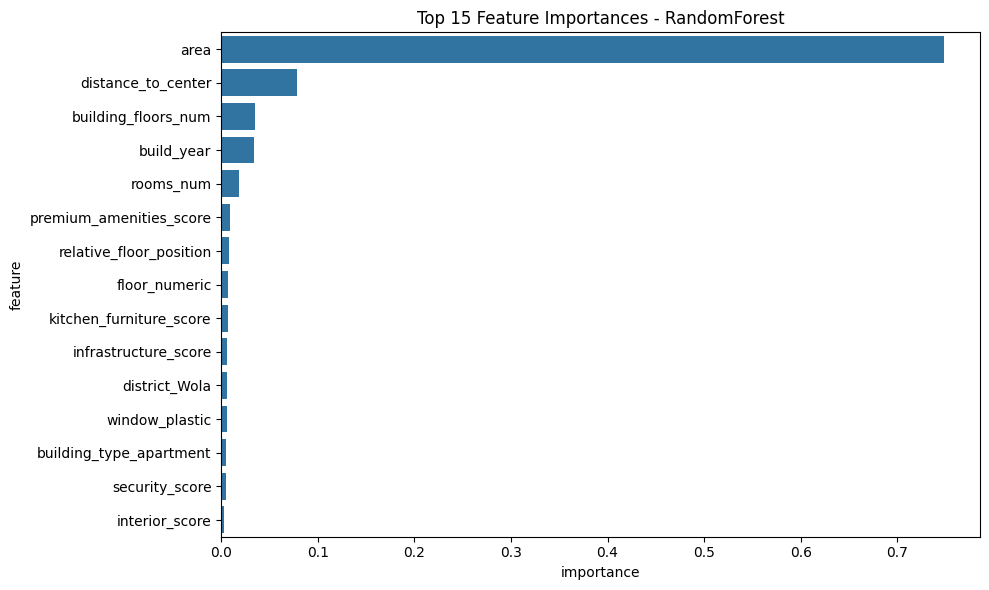

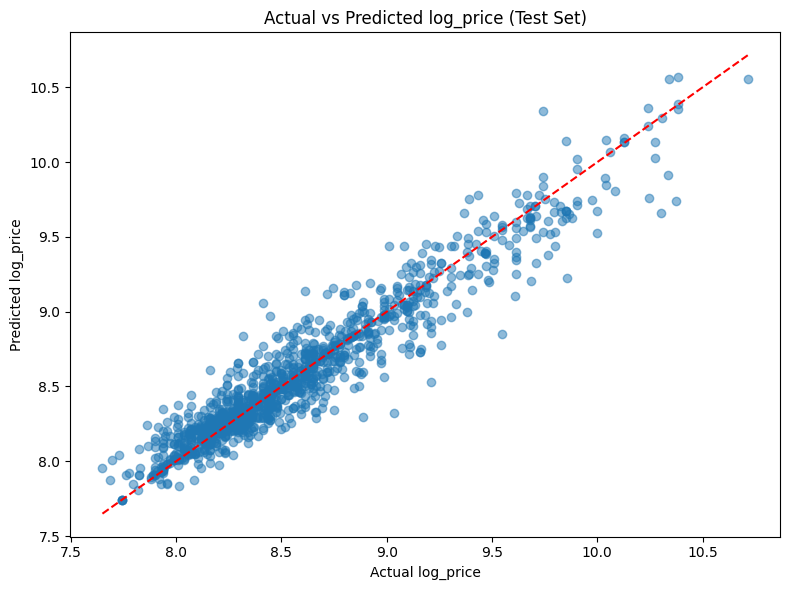


Sample predictions (log scale vs actual):
   Actual log_price  Predicted log_price  Difference  Actual Price (PLN)  \
0              8.16                 8.20       -0.04              3500.0   
1              7.91                 8.03       -0.12              2730.0   
2              8.05                 8.04        0.01              3147.0   
3              8.43                 8.47       -0.04              4600.0   
4              9.17                 9.39       -0.22              9600.0   

   Predicted Price (PLN)  Price Error (%)  
0                3632.86            -3.80  
1                3074.05           -12.60  
2                3107.39             1.26  
3                4781.76            -3.95  
4               12005.77           -25.06  


In [46]:

# Define regression models instead of classification models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Function to calculate regression metrics
def regression_metrics(y_true, y_pred):
    # Calculate metrics on log scale
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate metrics on original price scale
    y_true_exp = price_transform(y_true)
    y_pred_exp = price_transform(y_pred)
    mape = np.mean(np.abs((y_true_exp - y_pred_exp) / y_true_exp)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    metrics = regression_metrics(y_val, y_val_pred)
    metrics['model'] = model
    
    results[name] = metrics

# Print results
print("\nModel Validation Results:")
results_df = pd.DataFrame({name: {k: v for k, v in res.items() if k != 'model'} 
                          for name, res in results.items()}).T
print(results_df.sort_values('RMSE'))

# Find the best model based on RMSE
best_model_name = results_df['RMSE'].idxmin()
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
test_metrics = regression_metrics(y_test, y_test_pred)
print("\nBest model performance on test set:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# If the best model has feature importance, show it
if hasattr(best_model, 'feature_importances_'):
    # Plot feature importances for the best model
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
# Plot actual vs predicted for the best model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted log_price (Test Set)')
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.tight_layout()
plt.show()

# Show sample predictions
print("\nSample predictions (log scale vs actual):")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_df = pd.DataFrame({
    'Actual log_price': y_test.iloc[sample_indices].values,
    'Predicted log_price': y_test_pred[sample_indices],
    'Difference': y_test.iloc[sample_indices].values - y_test_pred[sample_indices],
    'Actual Price (PLN)': price_transform(y_test.iloc[sample_indices].values),
    'Predicted Price (PLN)': price_transform(y_test_pred[sample_indices]),
    'Price Error (%)': (price_transform(y_test.iloc[sample_indices].values) - price_transform(y_test_pred[sample_indices])) / 
                     price_transform(y_test.iloc[sample_indices].values) * 100
})
print(sample_df.round(2))

Adding engineered features...
Original features: 41
After feature engineering: 54
New features added: 13
Training set: 3632 samples (60.0%)
Validation set: 1211 samples (20.0%)
Test set: 1211 samples (20.0%)
Training model with original features...
Training model with engineered features...

Validation set performance comparison:
Original features - RMSE: 0.1600, R²: 0.9117, MAPE: 11.23%
Engineered features - RMSE: 0.1596, R²: 0.9122, MAPE: 11.16%

Improvement with feature engineering:
RMSE: 0.28% improvement
R²: 0.05% improvement
MAPE: 0.62% improvement

Final model performance on test set:
RMSE: 0.1548
R²: 0.9096
MAPE: 11.00%

Top 15 most important features (after engineering):
                      feature  importance
41              area_per_room    0.562732
0                        area    0.138119
42  area_distance_interaction    0.118203
32         distance_to_center    0.025449
2         building_floors_num    0.020858
47      high_premium_district    0.018918
3                

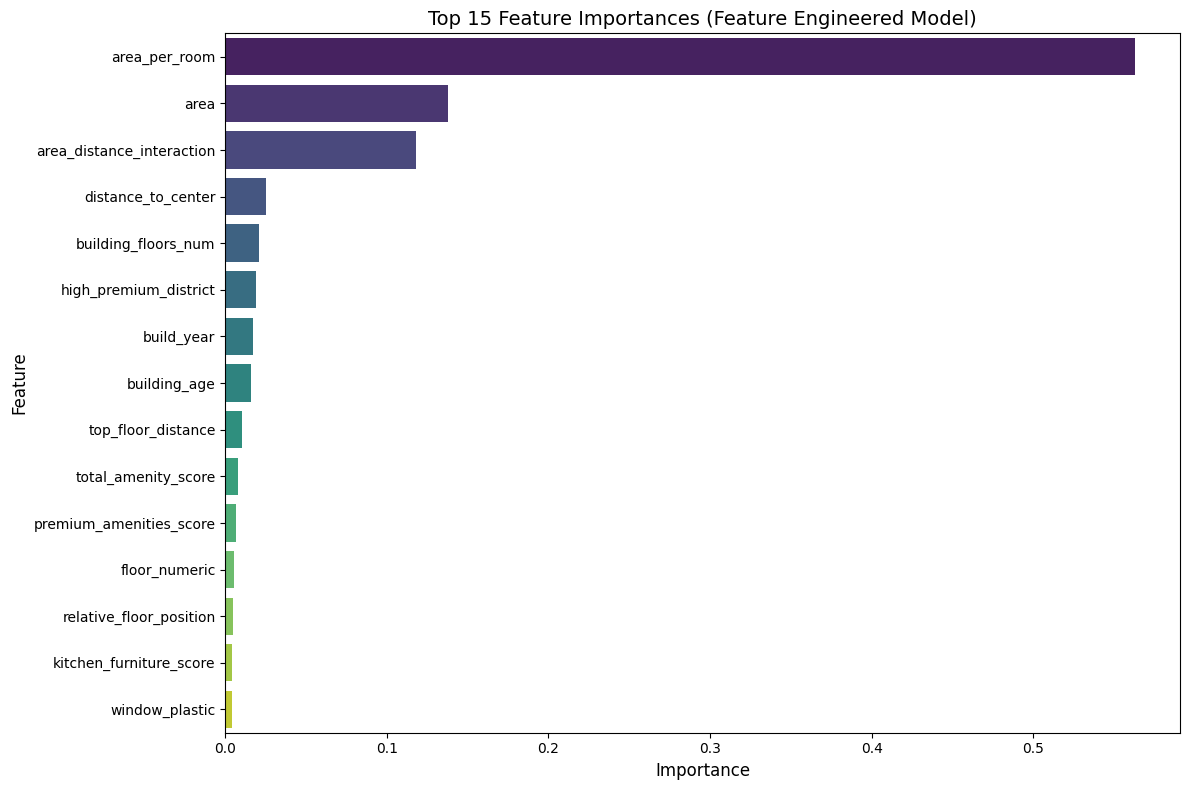

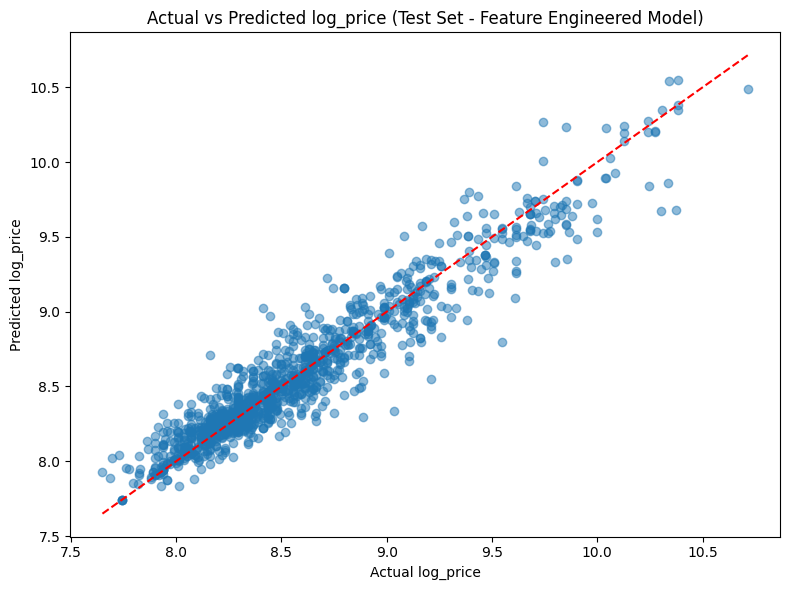


Ranking of engineered features by importance:
                            feature  importance
41                    area_per_room    0.562732
42        area_distance_interaction    0.118203
47            high_premium_district    0.018918
43                     building_age    0.015770
46               top_floor_distance    0.010182
44              total_amenity_score    0.007916
52         window_floor_interaction    0.002868
53  wooden_window_floor_interaction    0.001507
48          medium_premium_district    0.000970
45                 not_ground_floor    0.000271
51                  studio_property    0.000020
49                  luxury_property    0.000000
50                  family_property    0.000000


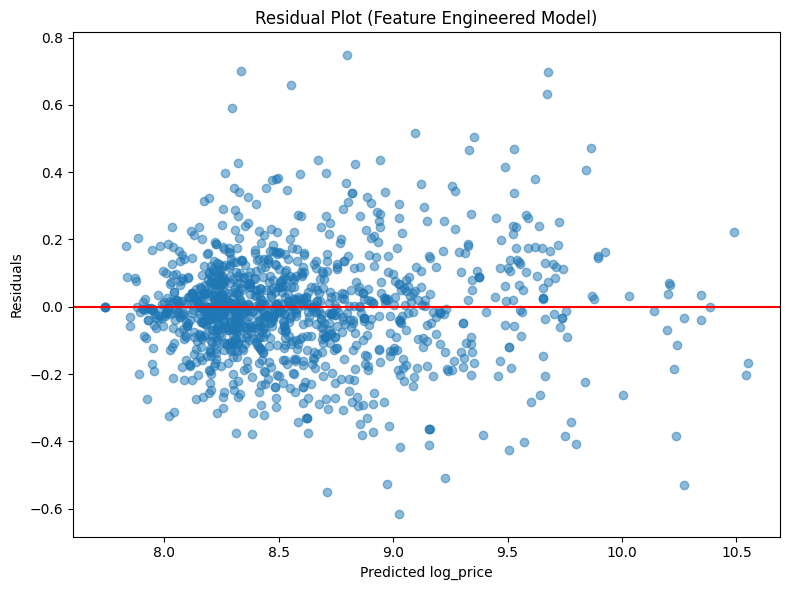

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 1. Create a copy of the original dataset before feature engineering
df_orig = X.copy()

# 2. Feature Engineering
print("Adding engineered features...")

# Create a copy of X for feature engineering
X_fe = X.copy()

# A. Area-related features
# Price per room (area divided by number of rooms)
X_fe['area_per_room'] = X_fe['area'] / X_fe['rooms_num'].replace(0, 1)  # Avoid division by zero

# B. Location interaction features
# Interaction between area and distance to center 
# (captures how the value of space changes with location)
X_fe['area_distance_interaction'] = X_fe['area'] * X_fe['distance_to_center']

# C. Building quality features
# Age of building (current year - build year)
current_year = 2025
X_fe['building_age'] = current_year - X_fe['build_year']

# D. Amenity aggregation
# Total amenity score (sum of all amenity scores)
amenity_columns = [
    'kitchen_furniture_score', 
    'security_score', 
    'tech_score', 
    'premium_amenities_score', 
    'infrastructure_score', 
    'interior_score'
]
X_fe['total_amenity_score'] = X_fe[amenity_columns].sum(axis=1)

# E. Floor-related features
# Distance from ground (for people who want to avoid ground floor)
X_fe['not_ground_floor'] = (X_fe['floor_numeric'] > 1).astype(int)

# Distance from top (some prefer not being on the top floor - roof issues, heat)
X_fe['top_floor_distance'] = X_fe['building_floors_num'] - X_fe['floor_numeric']

# F. District premium categories (based on prior district analysis)
# Group districts into premium tiers based on price
high_premium_districts = ['district_Śródmieście', 'district_Wola', 'district_Żoliborz', 'district_Wilanów']
medium_premium_districts = ['district_Mokotów', 'district_Praga-Północ', 'district_Ochota', 'district_Włochy']
X_fe['high_premium_district'] = X_fe[high_premium_districts].max(axis=1)
X_fe['medium_premium_district'] = X_fe[medium_premium_districts].max(axis=1)

# G. Property type aggregation (create meaningful property segments)
X_fe['luxury_property'] = ((X_fe['premium_amenities_score'] > 0) & 
                           (X_fe['area'] > X_fe['area'].mean()) & 
                           (X_fe['building_floors_num'] > 8)).astype(int)

X_fe['family_property'] = ((X_fe['rooms_num'] >= 3) & 
                           (X_fe['area'] > 60)).astype(int)

X_fe['studio_property'] = ((X_fe['rooms_num'] == 1) & 
                           (X_fe['area'] < 40)).astype(int)

# H. Window interaction (windows may matter more for higher floors)
X_fe['window_floor_interaction'] = X_fe['window_plastic'] * X_fe['floor_numeric']
X_fe['wooden_window_floor_interaction'] = X_fe['window_wooden'] * X_fe['floor_numeric']

# Print the number of new features added
print(f"Original features: {df_orig.shape[1]}")
print(f"After feature engineering: {X_fe.shape[1]}")
print(f"New features added: {X_fe.shape[1] - df_orig.shape[1]}")

# 3. Split the data using the feature-engineered dataset
X_temp, X_test, y_temp, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_fe):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_fe):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_fe):.1%})")

# 4. Train and evaluate the Random Forest model with engineered features
rf_orig = RandomForestRegressor(n_estimators=100, random_state=42)
rf_fe = RandomForestRegressor(n_estimators=100, random_state=42)

# Train both models
print("Training model with original features...")
rf_orig.fit(X_train[df_orig.columns], y_train)

print("Training model with engineered features...")
rf_fe.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_orig = rf_orig.predict(X_val[df_orig.columns])
y_val_pred_fe = rf_fe.predict(X_val)

# Calculate metrics
rmse_orig = np.sqrt(mean_squared_error(y_val, y_val_pred_orig))
r2_orig = r2_score(y_val, y_val_pred_orig)
mape_orig = np.mean(np.abs((price_transform(y_val) - price_transform(y_val_pred_orig)) / price_transform(y_val))) * 100

rmse_fe = np.sqrt(mean_squared_error(y_val, y_val_pred_fe))
r2_fe = r2_score(y_val, y_val_pred_fe)
mape_fe = np.mean(np.abs((price_transform(y_val) - price_transform(y_val_pred_fe)) / price_transform(y_val))) * 100

# Print comparison
print("\nValidation set performance comparison:")
print(f"Original features - RMSE: {rmse_orig:.4f}, R²: {r2_orig:.4f}, MAPE: {mape_orig:.2f}%")
print(f"Engineered features - RMSE: {rmse_fe:.4f}, R²: {r2_fe:.4f}, MAPE: {mape_fe:.2f}%")

# Calculate improvement percentage
rmse_improvement = ((rmse_orig - rmse_fe) / rmse_orig) * 100
r2_improvement = ((r2_fe - r2_orig) / r2_orig) * 100
mape_improvement = ((mape_orig - mape_fe) / mape_orig) * 100

print(f"\nImprovement with feature engineering:")
print(f"RMSE: {rmse_improvement:.2f}% improvement")
print(f"R²: {r2_improvement:.2f}% improvement")
print(f"MAPE: {mape_improvement:.2f}% improvement")

# 5. Evaluate on test set with the best model (feature engineered)
y_test_pred_fe = rf_fe.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_fe))
test_r2 = r2_score(y_test, y_test_pred_fe)
test_mape = np.mean(np.abs((price_transform(y_test) - price_transform(y_test_pred_fe)) / price_transform(y_test))) * 100

print(f"\nFinal model performance on test set:")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"MAPE: {test_mape:.2f}%")

# 6. Analyze feature importance after engineering
feature_importance = pd.DataFrame({
    'feature': X_fe.columns,
    'importance': rf_fe.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 most important features (after engineering):")
print(feature_importance.head(15))

# 7. Visualize top features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Feature Engineered Model)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 8. Visualize the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_fe, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted log_price (Test Set - Feature Engineered Model)')
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.tight_layout()
plt.show()

# 9. Optional: Analyze which engineered features provided the most benefit
new_features = [col for col in X_fe.columns if col not in df_orig.columns]
new_feature_importance = feature_importance[feature_importance['feature'].isin(new_features)]

print("\nRanking of engineered features by importance:")
print(new_feature_importance)

# 10. Analyze errors after feature engineering
residuals = y_test - y_test_pred_fe
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred_fe, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot (Feature Engineered Model)')
plt.xlabel('Predicted log_price')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

Adding selected engineered features...
Original features: 41
After adding selected engineered features: 46
New features added: 5
Training set: 3632 samples (60.0%)
Validation set: 1211 samples (20.0%)
Test set: 1211 samples (20.0%)
Training model with refined feature set...

Validation set performance:
RMSE: 0.1585
R²: 0.9134
MAPE: 11.18%

Performing hyperparameter tuning...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuned model validation performance:
RMSE: 0.1581
R²: 0.9139
MAPE: 11.12%

Final model performance on test set:
RMSE: 0.1542
R²: 0.9102
MAPE: 10.91%

Top 15 most important features:
                      feature  importance
41              area_per_room    0.561458
0                        area    0.137481
42  area_distance_interaction    0.120763
32         distance_to_center    0.027536
2         building_floors_num    0.022038
43      high_premium_district    0.018613
3                  build_year    0.017073

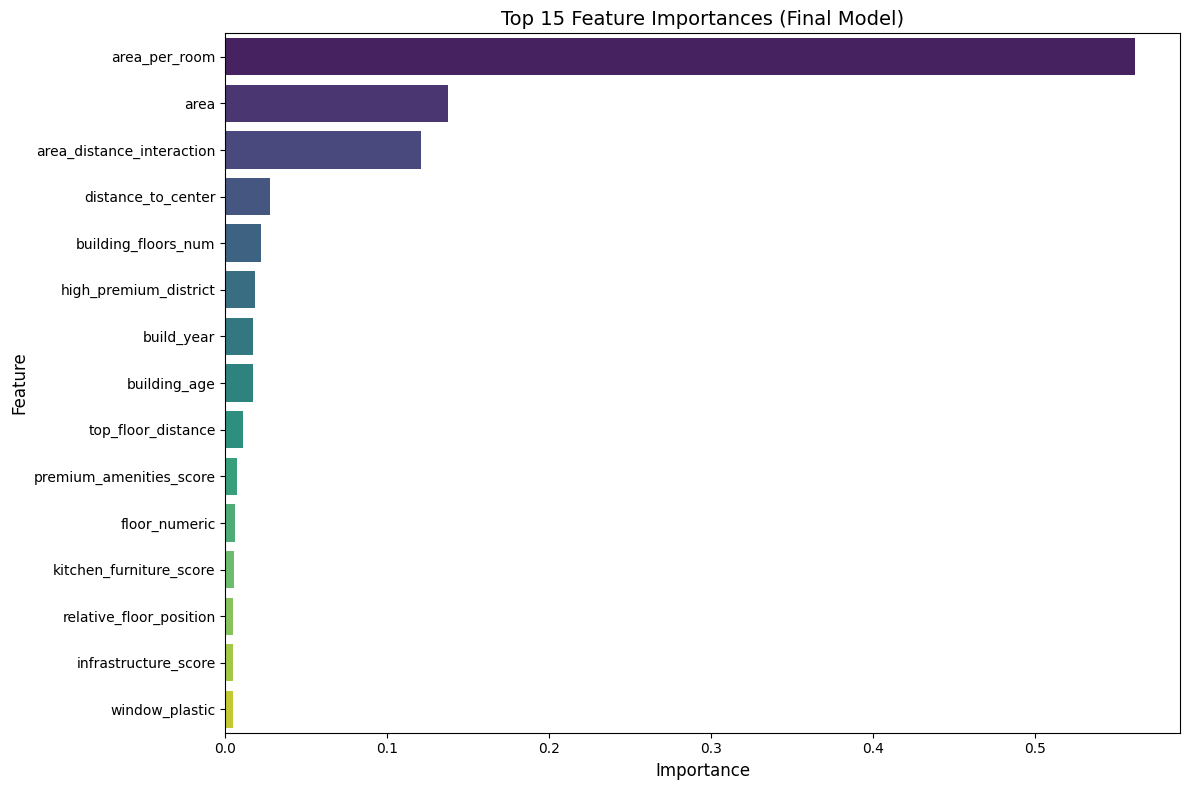

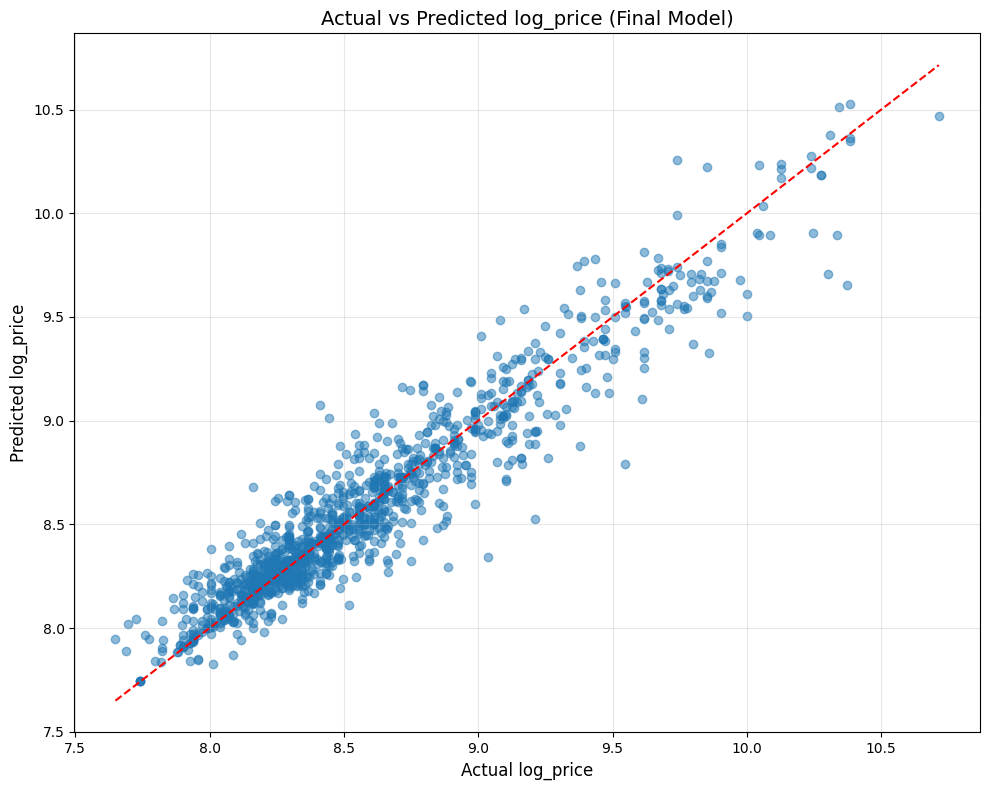


Sample predictions (log scale vs actual):
   Actual log_price  Predicted log_price  Difference  Actual Price (PLN)  \
0              9.62                 9.58        0.04             15000.0   
1              8.56                 8.40        0.16              5240.0   
2              8.29                 8.26        0.02              3980.0   
3              8.45                 8.33        0.12              4660.0   
4              8.99                 9.03       -0.04              8000.0   

   Predicted Price (PLN)  Price Error (%)  
0               14407.22             3.95  
1                4458.96            14.91  
2                3882.15             2.46  
3                4149.57            10.95  
4                8325.89            -4.07  
          area  rooms_num  building_floors_num  build_year  district_Bemowo  \
84    3.416929          4             0.797285   -0.063888                0   
4855 -0.603098          2             0.146778    0.806435                0   

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Start with your original features
X_refined = X.copy()

# Add only the most valuable engineered features
print("Adding selected engineered features...")

# 1. Area per room (most important feature)
X_refined['area_per_room'] = X_refined['area'] / X_refined['rooms_num'].replace(0, 1)

# 2. Area-distance interaction
X_refined['area_distance_interaction'] = X_refined['area'] * X_refined['distance_to_center']

# 3. High premium districts
high_premium_districts = ['district_Śródmieście', 'district_Wola', 'district_Żoliborz', 'district_Wilanów']
X_refined['high_premium_district'] = X_refined[high_premium_districts].max(axis=1)

# 4. Building age
current_year = 2025
X_refined['building_age'] = current_year - X_refined['build_year']

# 5. Top floor distance
X_refined['top_floor_distance'] = X_refined['building_floors_num'] - X_refined['floor_numeric']

print(f"Original features: {X.shape[1]}")
print(f"After adding selected engineered features: {X_refined.shape[1]}")
print(f"New features added: {X_refined.shape[1] - X.shape[1]}")

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X_refined, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_refined):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_refined):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_refined):.1%})")

# Train and evaluate with the refined feature set
rf_refined = RandomForestRegressor(n_estimators=100, random_state=42)
print("Training model with refined feature set...")
rf_refined.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_refined.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)
mape = np.mean(np.abs((price_transform(y_val) - price_transform(y_val_pred)) / price_transform(y_val))) * 100

print("\nValidation set performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Now let's do some hyperparameter tuning to further improve the model
print("\nPerforming hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

# Evaluate the tuned model
y_val_pred_tuned = best_rf.predict(X_val)
rmse_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_tuned))
r2_tuned = r2_score(y_val, y_val_pred_tuned)
mape_tuned = np.mean(np.abs((price_transform(y_val) - price_transform(y_val_pred_tuned)) / price_transform(y_val))) * 100

print("\nTuned model validation performance:")
print(f"RMSE: {rmse_tuned:.4f}")
print(f"R²: {r2_tuned:.4f}")
print(f"MAPE: {mape_tuned:.2f}%")

# Final evaluation on test set
y_test_pred = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((price_transform(y_test) - price_transform(y_test_pred)) / price_transform(y_test))) * 100

print("\nFinal model performance on test set:")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")
print(f"MAPE: {test_mape:.2f}%")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_refined.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 most important features:")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Final Model)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted log_price (Final Model)', fontsize=14)
plt.xlabel('Actual log_price', fontsize=12)
plt.ylabel('Predicted log_price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Sample predictions
print("\nSample predictions (log scale vs actual):")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_df = pd.DataFrame({
    'Actual log_price': y_test.iloc[sample_indices].values,
    'Predicted log_price': y_test_pred[sample_indices],
    'Difference': y_test.iloc[sample_indices].values - y_test_pred[sample_indices],
    'Actual Price (PLN)': price_transform(y_test.iloc[sample_indices].values),
    'Predicted Price (PLN)': price_transform(y_test_pred[sample_indices]),
    'Price Error (%)': (price_transform(y_test.iloc[sample_indices].values) - price_transform(y_test_pred[sample_indices])) / 
                     price_transform(y_test.iloc[sample_indices].values) * 100
})
print(sample_df.round(2))

sample_features = X_test.iloc[sample_indices]
print(sample_features)


In [49]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Save the final model and necessary preprocessing information
def save_model_artifacts(model, X_refined, X, scaler, features_to_standardize, current_year=2025):
    """
    Save the trained model and necessary preprocessing information for rental price prediction.
    
    Parameters:
    -----------
    model : estimator object
        The trained regression model (e.g., RandomForest, XGBoost)
    X_refined : DataFrame
        The feature DataFrame used for final model training, with the exact columns needed
    X : DataFrame
        The original feature DataFrame, used to identify categorical features
    scaler : StandardScaler
        The fitted scaler used to standardize numeric features
    features_to_standardize : list
        List of feature names that were standardized
    current_year : int, default=2025
        The current year, used for age calculations in future predictions
        
    Returns:
    --------
    None
        Saves the model artifacts to a file
    """
    # Identify categorical features more robustly
    categorical_features = [col for col in X.columns if (
        col.startswith('district_') or 
        col.endswith('_score') or 
        col.startswith('material_') or
        col.startswith('building_type_') or
        col.startswith('window_') or
        col.startswith('user_type_') or
        col.startswith('heating_') or
        col.startswith('construction_')
    )]
    
    # Identify high premium districts from your prediction function
    high_premium_districts = ['district_Śródmieście', 'district_Wola', 
                             'district_Żoliborz', 'district_Wilanów']
    
    # Dictionary to store all necessary artifacts
    model_artifacts = {
        'model': model,  # Your trained model
        'feature_names': X_refined.columns.tolist(),  # List of feature names
        'categorical_features': categorical_features,
        'current_year': current_year,  # For calculating building_age in future
        'high_premium_districts': high_premium_districts,
        'scaler': scaler,  # Store the fitted scaler
        'features_to_standardize': features_to_standardize,  # Which features to standardize
        'model_version': '1.0',
        'model_trained_date': pd.Timestamp.now().strftime('%Y-%m-%d')
    }
    
    try:
        # Save the artifacts
        joblib.dump(model_artifacts, 'warsaw_rental_model_artifacts.pkl')
        print("Model artifacts saved to 'warsaw_rental_model_artifacts.pkl'")
        return True
    except Exception as e:
        print(f"Error saving model artifacts: {e}")
        return False

# Example usage:
# save_model_artifacts(best_rf, X_refined, X, scaler, features_to_standardize)

In [50]:
def predict_rental_price(
    area, rooms_num, building_floors_num, build_year, distance_to_center, 
    floor_numeric, districts, building_type_apartment=0, building_type_tenement=0,
    window_plastic=0, window_wooden=0, user_type_agency=0, heating_urban=0,
    construction_ready_to_use=0, material_brick=0, material_concrete=0, 
    material_concrete_plate=0, relative_floor_position=None, is_top_floor=0,
    kitchen_furniture_score=0, security_score=0, tech_score=0, 
    premium_amenities_score=0, infrastructure_score=0, interior_score=0,
    deposit=0
):
    """
    Predict rental price in Warsaw based on property attributes.
    
    Parameters:
    -----------
    area : float
        Area of the property in square meters
    rooms_num : int
        Number of rooms
    building_floors_num : float
        Number of floors in the building
    build_year : int
        Year the building was constructed
    distance_to_center : float
        Distance to the city center in kilometers
    floor_numeric : float
        Which floor the property is on
    districts : str
        Property district (e.g., 'Śródmieście', 'Wola', etc.)
    deposit : float, optional
        Deposit amount (if applicable)
    Other parameters: Set to their default values unless specified
    
    Returns:
    --------
    dict
        Containing predicted price, log_price, and price_per_sqm
    """
    # Load model artifacts
    artifacts = joblib.load('warsaw_rental_model_artifacts.pkl')
    model = artifacts['model']
    feature_names = artifacts['feature_names']
    high_premium_districts = artifacts['high_premium_districts']
    current_year = artifacts['current_year']
    scaler = artifacts['scaler']
    features_to_standardize = artifacts['features_to_standardize']
    
    # Initialize feature dictionary with zeros
    features = {feature: 0 for feature in feature_names}
    
    # Fill in basic features
    features['area'] = area
    features['rooms_num'] = rooms_num
    features['building_floors_num'] = building_floors_num
    features['build_year'] = build_year
    features['distance_to_center'] = distance_to_center
    features['floor_numeric'] = floor_numeric
    
    # Add deposit if it's in the features
    if 'deposit' in features:
        features['deposit'] = deposit
    
    # Set district indicator
    district_col = f'district_{districts}'
    if district_col in features:
        features[district_col] = 1
    
    # Fill in other provided features
    features['building_type_apartment'] = building_type_apartment
    features['building_type_tenement'] = building_type_tenement
    features['window_plastic'] = window_plastic
    features['window_wooden'] = window_wooden
    features['user_type_agency'] = user_type_agency
    features['heating_urban'] = heating_urban
    features['construction_ready_to_use'] = construction_ready_to_use
    features['material_brick'] = material_brick
    features['material_concrete'] = material_concrete
    features['material_concrete_plate'] = material_concrete_plate
    
    # Calculate relative_floor_position if not provided
    if relative_floor_position is None and building_floors_num > 0:
        features['relative_floor_position'] = floor_numeric / building_floors_num
    else:
        features['relative_floor_position'] = relative_floor_position
    
    features['is_top_floor'] = is_top_floor
    
    # Set amenity scores
    features['kitchen_furniture_score'] = kitchen_furniture_score
    features['security_score'] = security_score
    features['tech_score'] = tech_score
    features['premium_amenities_score'] = premium_amenities_score
    features['infrastructure_score'] = infrastructure_score
    features['interior_score'] = interior_score
    
    # Calculate engineered features
    features['area_per_room'] = area / max(rooms_num, 1)  # Avoid division by zero
    features['area_distance_interaction'] = area * distance_to_center
    
    # Set high premium district flag
    features['high_premium_district'] = 1 if district_col in high_premium_districts else 0
    
    # Calculate building age
    features['building_age'] = current_year - build_year
    
    # Calculate top floor distance
    features['top_floor_distance'] = building_floors_num - floor_numeric
    
    # Convert to DataFrame with correct feature order
    input_df = pd.DataFrame([features])
    
    # Apply standardization to numeric features
    standardize_features = [f for f in features_to_standardize if f in input_df.columns]
    if standardize_features:
        input_df[standardize_features] = scaler.transform(input_df[standardize_features])
    
    # Select only the columns used by the model
    input_df = input_df[feature_names]
    
    # Make prediction
    log_price_pred = model.predict(input_df)[0]
    price_pred = np.exp(log_price_pred)  # Assuming price_transform is just np.exp()
    price_per_sqm = price_pred / area
    
    return {
        'predicted_price': round(price_pred, 2),
        'predicted_log_price': round(log_price_pred, 4),
        'predicted_price_per_sqm': round(price_per_sqm, 2)
    }

In [51]:
# Test the prediction function with a sample property
test_prediction = predict_rental_price(
    area=55,
    rooms_num=3,
    building_floors_num=5,
    build_year=2015,
    distance_to_center=4.5,
    floor_numeric=3,
    districts='Wola',
    building_type_apartment=1,
    window_plastic=1,
    heating_urban=1,
    premium_amenities_score=1
)

print("Sample prediction:")
print(f"Predicted rental price: {test_prediction['predicted_price']} PLN")
print(f"Predicted price per sqm: {test_prediction['predicted_price_per_sqm']} PLN/sqm")

KeyError: 'scaler'

In [37]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_info_columns', 10000)  # Ensures no cutoff in df.info()
from io import StringIO


buffer = StringIO()
df.info(verbose=True, show_counts=True, buf=buffer)
info_str = buffer.getvalue()
print(info_str)  # Now you'll see all columns including column 20
with open("df_info.txt", "w") as f:
    df.info(verbose=True, show_counts=True, buf=f)
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   area                              6054 non-null   float64
 1   rooms_num                         6054 non-null   int64  
 2   building_floors_num               6054 non-null   float64
 3   deposit                           6054 non-null   float64
 4   build_year                        6054 non-null   float64
 5   total_price                       6054 non-null   float64
 6   district_standardized             6054 non-null   object 
 7   district_Bemowo                   6054 non-null   int64  
 8   district_Białołęka                6054 non-null   int64  
 9   district_Bielany                  6054 non-null   int64  
 10  district_Mokotów                  6054 non-null   int64  
 11  district_Ochota                   6054 non-null   int64  
 12  distri

,area,rooms_num,building_floors_num,deposit,build_year,total_price,district_standardized,district_Bemowo,district_Białołęka,district_Bielany,district_Mokotów,district_Ochota,district_Other,district_Praga-Południe,district_Praga-Północ,district_Targówek,district_Ursus,district_Ursynów,district_Wilanów,district_Wola,district_Włochy,district_Śródmieście,district_Żoliborz,district_other,building_type_standardized,building_type_apartment,building_type_tenement,windows_type_standardized,window_plastic,window_wooden,user_type_standardized,user_type_agency,heating_standardized,heating_urban,construction_status_standardized,construction_ready_to_use,building_material_standardized,material_brick,material_concrete,material_concrete_plate,floor_standardized,floor_numeric,distance_to_center,relative_floor_position,is_top_floor,property_age_group,log_price,kitchen_furniture_score,security_score,tech_score,premium_amenities_score,infrastructure_score,interior_score
0,0.290241,3,-0.503729,0.925295,0.608635,9750.0,Ochota,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,apartment,1,0,wooden,0,1,private_owner,0,urban,1,ready_to_use,1,brick,1,0,0,3,-0.186078,-0.812307,0.601185,0,Recent,9.185023,7,5,2,2,3,1
1,0.081795,3,0.146778,0.000062,0.489954,5700.0,Ursynów,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,apartment,1,0,plastic,1,0,private_owner,0,urban,1,ready_to_use,1,brick,1,0,0,5,0.537905,0.279218,0.248404,0,Recent,8.648221,7,3,2,1,3,2
2,-0.811544,2,1.447792,-0.218629,0.727315,3900.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,block,0,0,plastic,1,0,private_owner,0,urban,1,ready_to_use,1,concrete_plate,0,0,1,9,1.985873,0.025501,0.072014,0,New,8.268732,6,2,0,0,3,0
3,-0.126651,3,-0.666356,-0.084050,0.806435,4300.0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,block,0,0,plastic,1,0,private_owner,0,Other,0,Other,0,Other,0,0,0,2,-0.548070,3.993850,0.365998,0,New,8.366370,5,3,2,0,3,1
4,0.141351,3,1.610419,1.009407,0.292153,9500.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,apartment,1,0,Other,0,0,agency,1,urban,1,Other,0,Other,0,0,0,1,-0.910062,-0.162352,-1.349484,0,Recent,9.159047,1,3,2,1,3,0
5,0.141351,3,2.748807,0.126230,0.292153,7500.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Other,0,0,Other,0,0,agency,1,Other,0,Other,0,Other,0,0,0,2,-0.548070,-0.162352,-1.280312,0,Recent,8.922658,1,0,0,0,3,1
6,-0.483986,2,0.146778,-0.126106,0.845996,3880.0,Praga-Południe,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,block,0,0,plastic,1,0,private_owner,0,urban,1,ready_to_use,1,Other,0,0,0,5,0.537905,0.740830,0.248404,0,New,8.263590,6,3,3,0,2,0
7,-0.314252,2,-0.828983,-0.126106,0.292153,4164.0,Włochy,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,block,0,0,Other,0,0,agency,1,Other,0,ready_to_use,1,Other,0,0,0,2,-0.548070,0.718798,1.306746,1,Recent,8.334231,6,2,1,0,2,0
8,-0.007539,3,-0.178476,-0.252274,0.292153,4200.0,Targówek,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,block,0,0,plastic,1,0,private_owner,0,urban,1,Other,0,Other,0,0,0,4,0.175913,-0.022848,0.365998,0,Recent,8.342840,6,2,0,0,1,1
9,4.161379,4,0.472031,0.672959,0.054792,15200.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Other,0,0,plastic,1,0,agency,1,Other,0,ready_to_use,1,Other,0,0,0,6,0.899897,-1.256121,0.177848,0,Modern,9.629051,6,0,0,0,2,0
